In [1]:
import numpy as np
from matplotlib.ticker import PercentFormatter

from src.neurons import *
import src.neurons
import src.tpam_tool as tp
from src.tpam_tool import *
import matplotlib.pyplot as plt

# times new roman for matplot
plt.rcParams['font.family'] = 'Times New Roman'


In [2]:
def cal_energy(x, W, c_thresh):
    x_star = np.conj(x)
    res = -0.5 * x_star @ W @ x + c_thresh * (x_star @ x)
    # print('res: ', res)
    return np.real(res)


def cal_similarity(x, y):
    angles_x = np.angle(x)/np.pi/2
    angles_y = np.angle(y)/(np.pi*2)

    mse = 0
    error_count = 0
    count = 0

    for i in range(len(x)):
        if np.abs(x[i]) > 0.05 and np.abs(y[i]) > 0.05:
            mse += (angles_x[i] - angles_y[i]) ** 2
            count += 1
        elif np.abs(x[i]) > 0.05 or np.abs(y[i]) > 0.05:
            error_count += 1.0
            count += 1

    if count == 0:
        return 0  # Return infinity if no valid elements are found

    mse = np.sqrt(mse)
    return 1 - (mse+error_count)/count  # Return the normalized

def cal_mse(x, y):
    angle_x = np.angle(x)
    angle_y = np.angle(y)
    mse = np.mean((angle_x - angle_y) ** 2)
    return mse

# Parameteres

In [3]:
N_vec = 25*25 # size of each pattern
N_out = 600 # 600 patterns
K = int(0.05 * N_vec)
Ks = int(0.05 * N_vec)

Generate samples. You can also load the provided sample as well.

In [4]:
# pvecs = tp.crvec(N_vec, N_out).T
#
# for d in range(N_out):
#     ip = np.random.choice(N_vec, size=(N_vec-K), replace=False)
#     pvecs[ip, d] = 0

# load the pvecs
pvecs = tp.load_complex_matrix('src/samples/pw_pvecs25_600.npz')

Matrix loaded from src/samples/pw_pvecs25_600.npz


Learning the weight matrices.

In [5]:
pmat_stdp = tp.stdp_learn(pvecs, epochs=1, An = 0.8, Ap = 0.8, tau_n = 0.4, tau_p = 0.4)/Ks
pmat = np.dot(pvecs, np.conj(pvecs.T))/Ks
np.fill_diagonal(pmat, 0)

0th training epoch
0.0%th column processed
10.0%th column processed
20.0%th column processed
30.0%th column processed
40.0%th column processed
50.0%th column processed
60.0%th column processed
70.0%th column processed
80.0%th column processed
90.0%th column processed


Select one pattern, and then mask it. Then prepare to do iterations.

In [6]:
target_id = 82
target_vec = pvecs[:,target_id].copy()
target_cue = target_vec.copy()
target_cue[:int(N_vec*2/3)] = 0
retrival_vec = target_cue/norm(target_cue)
retrival_vec_stdp = retrival_vec.copy()
max_steps = 50

energy = [cal_energy(retrival_vec, pmat, 0.6/Ks**0.5)]
similarity = [cal_similarity(retrival_vec, target_vec)]
losses = [cal_mse(retrival_vec, target_vec)]
energy_stdp = [cal_energy(retrival_vec_stdp, pmat_stdp, 0.6/Ks**0.5)]
similarity_stdp = [cal_similarity(retrival_vec_stdp, target_vec)]
losses_stdp = [cal_mse(retrival_vec_stdp, target_vec)]

Iteration.

In [7]:
for _ in range(max_steps):
    retrival_vec = np.dot(pmat, retrival_vec)
    retrival_vec = activation_thresh(retrival_vec, 0.6/Ks**0.5)
    retrival_vec /= norm(retrival_vec)
    energy.append(cal_energy(retrival_vec, pmat, 0.6/Ks**0.5))
    similarity.append(cal_similarity(retrival_vec, target_vec))
    losses.append(cal_mse(retrival_vec, target_vec))

    retrival_vec_stdp = np.dot(pmat_stdp, retrival_vec_stdp)
    retrival_vec_stdp = activation_thresh(retrival_vec_stdp, 0.6/Ks**0.5)
    retrival_vec_stdp /= norm(retrival_vec_stdp)
    energy_stdp.append(cal_energy(retrival_vec_stdp, pmat_stdp, 0.6/Ks**0.5))
    similarity_stdp.append(cal_similarity(retrival_vec_stdp, target_vec))
    losses_stdp.append(cal_mse(retrival_vec_stdp, target_vec))

Display results.

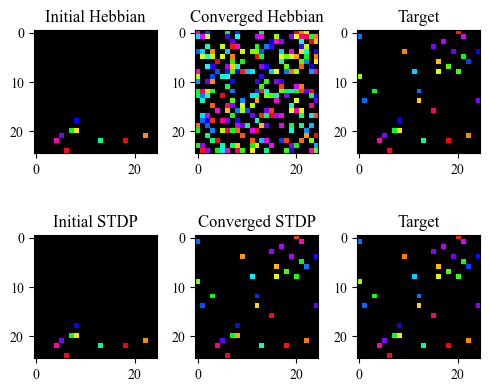

In [8]:
plt.figure(figsize=(5,4.25))

plt.subplot(231)
plt.imshow(cviz_im(target_cue))
plt.title('Initial Hebbian')
plt.subplot(232)
plt.imshow(cviz_im(retrival_vec))
plt.title('Converged Hebbian')
plt.subplot(233)
plt.imshow(cviz_im(target_vec))
plt.title('Target')
plt.subplot(234)
plt.imshow(cviz_im(target_cue))
plt.title('Initial STDP')
plt.subplot(235)
plt.imshow(cviz_im(retrival_vec_stdp))
plt.title('Converged STDP')
plt.subplot(236)
plt.imshow(cviz_im(target_vec))
plt.title('Target')
plt.tight_layout()
plt.show()

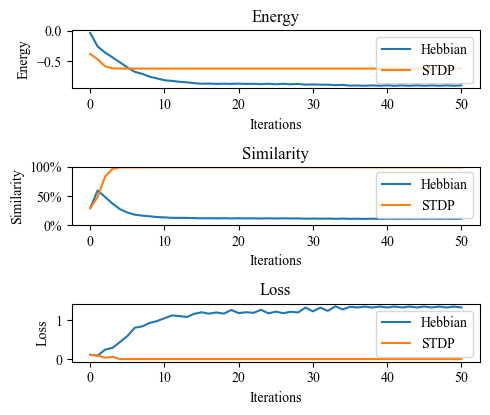

In [9]:
plt.figure(figsize=(5, 4.25))
plt.subplot(311)
plt.plot(energy, label='Hebbian')
plt.plot(energy_stdp, label='STDP')
plt.title('Energy')
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

plt.subplot(312)
plt.plot(similarity, label='Hebbian')
plt.plot(similarity_stdp, label='STDP')
plt.title('Similarity')
plt.xlabel('Iterations')
plt.ylabel('Similarity')
# y max = 100%
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()

plt.subplot(313)
plt.plot(losses, label='Hebbian')
plt.plot(losses_stdp, label='STDP')
plt.title('Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()